# AdventureWorks Försäljningsanalys
I denna analys undersöker AdventureWorks-databasen för att besvara affärsfrågor som exempelvis:
- Produktkategori och deras försäljning
- Försäljningstrender över tid
- Regional försäljning

Vi använder SQL för att hämta data och Python för visualisering och analys.

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("")
server = "localhost:1433"
database = "AdvetureWorks2025"
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)


def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

Anslutning till SQL Server lyckades


C:\Users\Speldator\AppData\Local\Temp\ipykernel_41972\2285982076.py:22: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


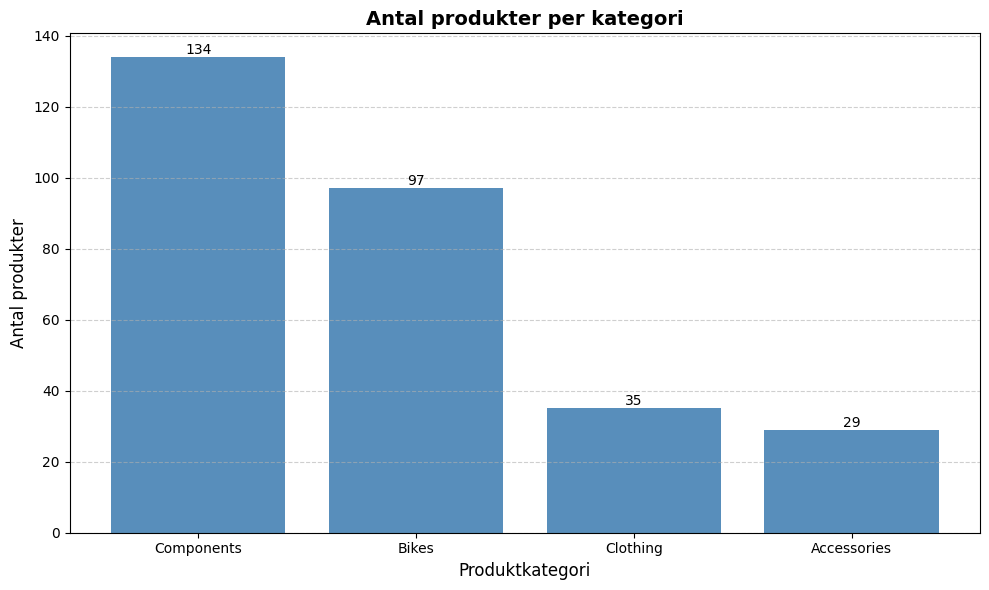

In [2]:
from src import viz as V

query_vis_1 = """
SELECT 
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
JOIN Production.ProductSubcategory psc ON psc.ProductCategoryID = pc.ProductCategoryID
JOIN Production.Product p ON p.ProductSubcategoryID = psc.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis_1)

fig, ax = plt.subplots(figsize=(10, 6))

V.bar(
    ax,
    df_vis1,
    x_col="CategoryName",
    y_col="ProductCount",
    title="Antal produkter per kategori",
    xlabel="Produktkategori",
    ylabel="Antal produkter"
)

plt.tight_layout()
plt.show()


## Visualisering 1: Antal produkter per kategori
Hur många produkter finns i varje kategori?

Tabeller som används:
Production.ProductCategory
Production.ProductSubcategory
Production.Product

Plan:
JOINA tabellerna
Räkna DISTINCT produkter per kategori
Skapa vertikalt stapeldiagram
Analysera resultatet

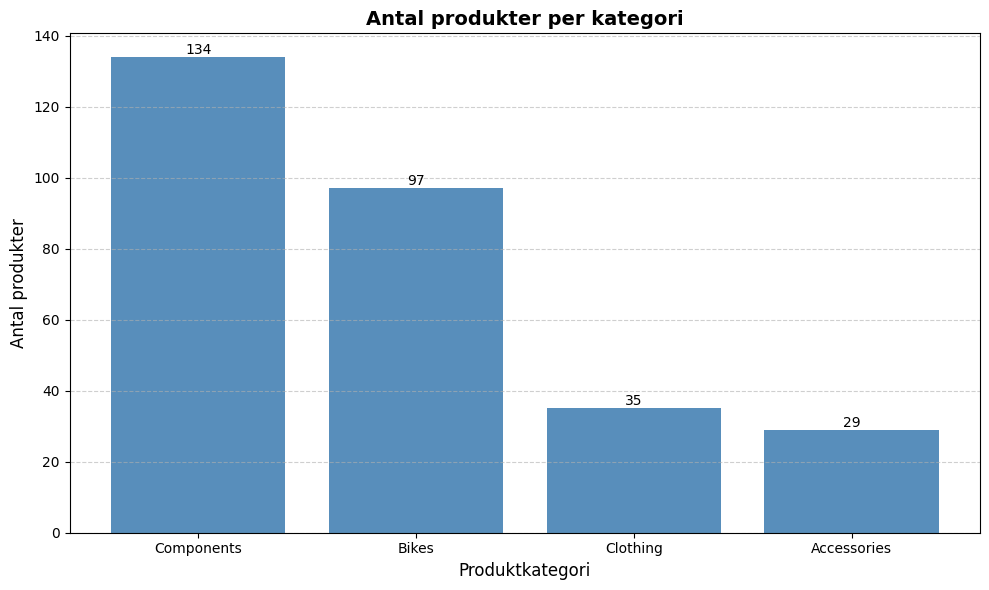

In [3]:
query_vis_1 = """
SELECT 
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
JOIN Production.ProductSubcategory psc ON psc.ProductCategoryID = pc.ProductCategoryID
JOIN Production.Product p ON p.ProductSubcategoryID = psc.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis_1)



fig, ax = plt.subplots(figsize=(10,6))
# ax.set_axisbelow(True)
ax.grid(True, axis='y', linestyle='--', alpha=0.6)


bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='steelblue', alpha=0.9)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )



ax.set_xlabel("Produktkategori", fontsize=12)
ax.set_ylabel("Antal produkter", fontsize=12)
ax.set_title("Antal produkter per kategori", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

### Insikter - Antal produkter per kategori
Components är största kategorin med 134 produkter.
Accessories är minst med 29 produkter.

Detta indiketar på att företaget är starkt fokucerat på komponenter och reserdelar.
Och att accessories kan vara ett utvecklingsområde.

# Visualisering 2: Försäljning per produktkategori

Vilka produktkategorier genererar mest intäkter?

Använd tabeller: Production.ProductCategory, Production.ProductSubcategory, Production.Product, Sales.SalesOrderDetail

Plan: Joina tabellerna kör en order by DESC. Visulaisera med horisontell stapeldiagram

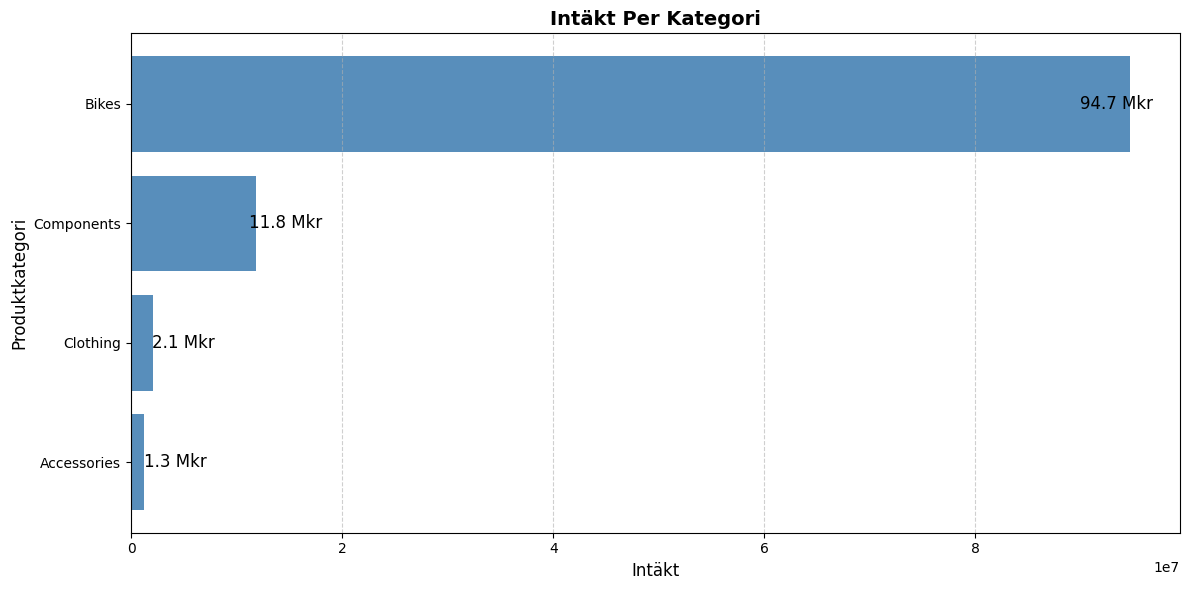

In [4]:

query_vis_2 = '''
SELECT
    ppc.ProductCategoryID,
    ppc.Name,
    SUM(ssod.LineTotal) AS IntäktPerKategori
FROM Production.ProductCategory ppc
INNER JOIN Production.ProductSubcategory ppsc
    ON ppsc.ProductCategoryID = ppc.ProductCategoryID
INNER JOIN Production.Product pp
    ON pp.ProductSubcategoryID = ppsc.ProductSubcategoryID
INNER JOIN sales.SalesOrderDetail ssod
    ON ssod.ProductID = pp.ProductID
GROUP BY
    ppc.ProductCategoryID,
    ppc.Name
ORDER BY IntäktPerKategori DESC
'''

df_vis2 = query_df(query_vis_2)


fig, ax = plt.subplots(figsize=(12, 6))

V.barh(
    ax,
    df_vis2,
    x_col="IntäktPerKategori",
    y_col="Name",
    title="Intäkt Per Kategori",
    xlabel="Intäkt",
    ylabel="Produktkategori"
)

ax.invert_yaxis()
plt.tight_layout()
plt.show()

### Insikter - Försäljning per produktkategori
Bikes är största kategorin med försäljning på ca 94.7 Mkr.
Accessories är minst med försäljning på 1.3 Mkr.

Detta indiketar på att företaget är starkt fokucerat på Bikes.
Och att accessories kan vara ett utvecklingsområde.

# Visualisering 3: Försäljning över tid

Hur har försäljningen utvecklats över tid?

Använd tabellen: Sales.SalesOrderHeader

Plan: Gruppera på år och månad, summera försäljningen. Sortera ASC (Äldst först)

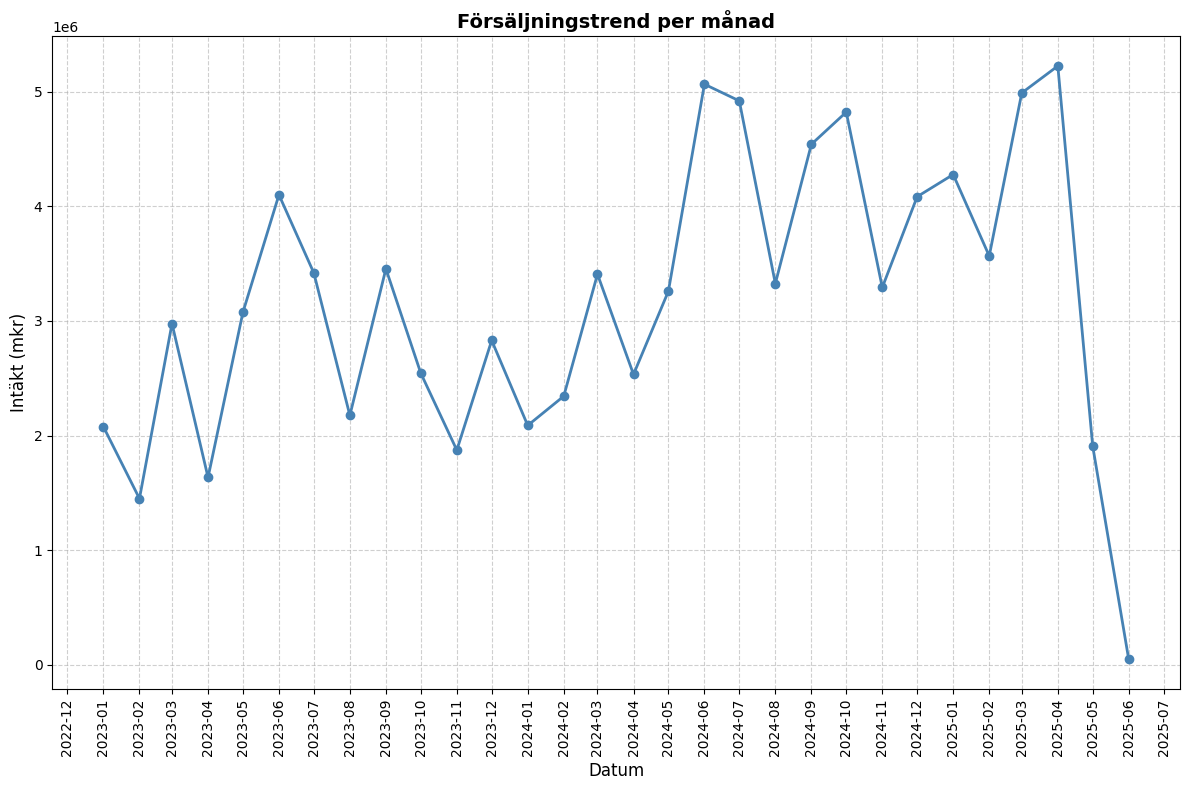

In [5]:
query_vis_3 = '''
SELECT
    DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate),1) AS Datum,
    SUM(SubTotal) AS Intäkt
FROM Sales.SalesOrderHeader
WHERE YEAR(OrderDate) >= 2023
GROUP BY YEAR(OrderDate), MONTH(OrderDate)
ORDER BY Datum
'''

df_vis3 = query_df(query_vis_3)


fig, ax = plt.subplots(figsize=(12,8))

V.line(
    ax,
    df_vis3,
    x_col="Datum",
    y_col="Intäkt",
    title="Försäljningstrend per månad",
    xlabel="Datum",
    ylabel="Intäkt (mkr)",
    marker="o"
)

plt.tight_layout()
plt.show()

### Insikter - Försäljning över tid
Försäljningstrenden ser ut till att öka, dock ett större tapp i maj & juni 2025.
Under 2023 och 2024 var försäljningen sämre under februari, april, augusti och november. 
Dessa månader kanske bör undersökas vidare för att eventuellt försöka boosta försäljningen.

Det ser ut som att försäljningen tar fart under våren och toppar under sommaren. 

Lägsta försäljningen var i juni 2025.
Högsta försäljningen var i april 2025.



# Visualisering 4: Försäljning och antal ordrar per år

Hur ser total försäljning och antal ordrar ut per år?

Använd tabellen: Sales.SalesOrderHeader

Plan: Gruppera per år, summera försäljningen, räkna alla rader. Sortera ASC (Äldst först)

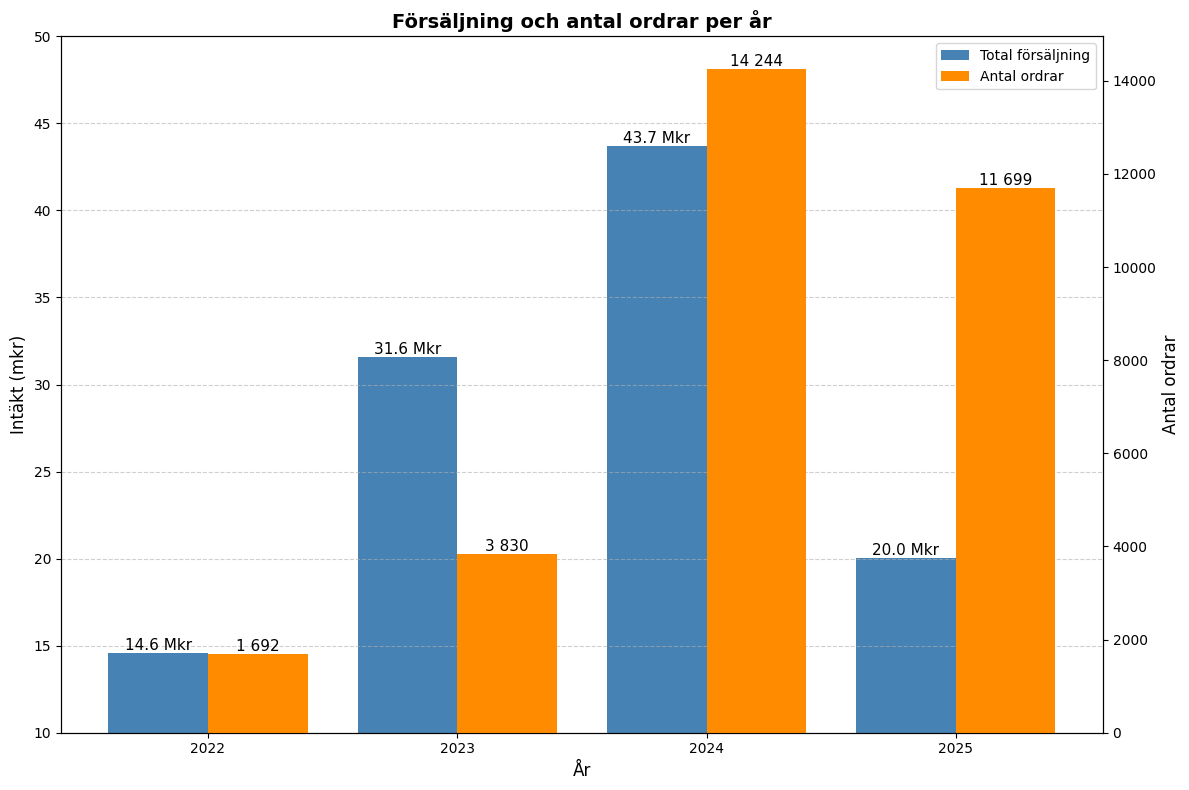

In [6]:
query_vis_4 = '''
SELECT
    YEAR(OrderDate) AS År,
    SUM(SubTotal) AS Intäkt,
    COUNT(*) As AntalOrdrar
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY År
'''

df_vis4 = query_df(query_vis_4)


fig, ax = plt.subplots(figsize=(12,8))


V.grouped_bar(
    ax,
    df_vis4,
    x_col="År",
    y_col1="Intäkt",
    y_col2="AntalOrdrar",
    label1="Total försäljning",
    label2="Antal ordrar",
    title="Försäljning och antal ordrar per år",
    xlabel="År",
    ylabel1="Intäkt (mkr)",
    ylabel2="Antal ordrar",
    width=0.4
)

ax.set_ylim(10_000_000, 50_000_000)
plt.tight_layout()
plt.show()


### Insikter - Försäljning och antal ordrar per år
Högst försäljning gjordes år 2024. Då var både antalet ordrar och total intäkt störst.
<br>Från 2022 t.o.m. 2024 ser både försäljningen och antalet ordrar ut att öka.


Det ser svårt ut att trenden ska fortsätta öka med tanke på att juni 2025 var den sämsta månaden.
Men det är fortfarande 6 månader kvar av 2025. <br>Antalet ordrar kommer förmodligen följa trenden genom att stiga. Det blir nog svårare med total försäljning då störst försäljning tidigare skett under vår/sommar.
